In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/DL/project
!ls

/content/drive/My Drive/DL/project
50		 cifar-10	      skipthoughts.py
60		 cookies.txt	      skipthought_vectors.pkl
75		 dictionary.txt       skipthought_vectors_test.pkl
ArjunData	 facenet_keras.h5     snapshots
bi_skip.npz	 image_names.txt      test_data.h5
bi_skip.npz.pkl  init.py	      test_img_names.pkl
btable.npy	 losses_list_2400.h5  train_data.h5
caps.json	 losses_list_4800.h5  train_img_names_1.pkl
captions.txt	 models		      uni_skip.npz
celeba		 __pycache__	      uni_skip.npz.pkl
celeba.zip	 Refrences.gdoc       utable.npy


In [ ]:
import os
import sys
import numpy as np
from random import shuffle
import tensorflow as tf
from keras.preprocessing.image import img_to_array,load_img
from PIL import Image
import math
import random
from collections import Counter
import nltk
import json
import h5py
import pickle
import skipthoughts
import re
import urllib.request
from mpl_toolkits.axes_grid1 import ImageGrid
import zipfile
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Reshape,concatenate,Flatten,Lambda,LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D,Conv2D,MaxPooling2D,Conv2DTranspose
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal,Zeros,RandomNormal,Constant
from keras import backend as K
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import time
import cv2
from keras.models import load_model
from scipy import spatial
nltk.download('punkt')
print("GPU:",tf.test.gpu_device_name(),"TF version:",tf.__version__)

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
GPU: /device:GPU:0 TF version: 2.2.0


In [ ]:
def plot_batch(generated_images,model_name,epoch,batch_idx,snapshot_dir_path,text_dim):
    fig=plt.figure(1)
    grid=ImageGrid(fig,111,nrows_ncols=(2,8),axes_pad=0.05)
    size=2*8
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow((generated_images[i]*255).astype(np.uint8))
    plt.savefig(os.path.join(snapshot_dir_path,model_name+'-'+str(text_dim)+'-'+str(epoch)+'-'+str(batch_idx)+'.png'))

def img_from_normalised_img(normalised_img):
    image=normalised_img.astype(float)*255
    image=image.astype('uint8')
    return image

def load_normalised_img_and_cap(json_file_path,skipthought_dim):
    train_imgs=h5py.File('./train_data.h5','r')
    imgs=train_imgs['imgs']
    imgs=np.array(imgs)
    print(imgs.shape)
    names_in=open('./train_img_names_1.pkl','rb')
    names=pickle.load(names_in)
    
    with open(json_file_path,'r') as j:
        caps=json.loads(j.read())
    
    captions=[]
    for i in range(len(names)):
        captions.append(caps[names[i]])
    
    if not os.path.exists('./skipthought_vectors.pkl'):
        model=skipthoughts.load_model()
        vectors=skipthoughts.encode(model,captions)
        with open('skipthought_vectors.pkl','wb') as f:
            pickle.dump(vectors,f)
    else:
        with open('skipthought_vectors.pkl','rb') as f:
            vectors=pickle.load(f)
    if skipthought_dim!=4800:
        vectors=vectors[:,:2400]

    result=[]
    for i in range(len(imgs)):
        result.append([imgs[i],vectors[i],names[i]])
    
    return np.array(result)

def resize(img,input_shape):
  height,width=input_shape
  return cv2.resize(img,(width,height))

In [ ]:
class DCGan(object):
    def __init__(self):
        self.generator=None
        self.discriminator=None
        self.model=None
        self.img_width=7
        self.img_height=7
        self.img_channels=1
        self.text_input_dim=4800
        self.random_input_dim=100
        self.model_dir_path=None
        self.model_name='dc_gan'
        self.config=None
    
    def get_config_file_path(self,model_dir_path):
        return os.path.join(self.model_dir_path,self.model_name+str(self.text_input_dim)+'-config.npy')
    
    def get_weight_file_path(self,model_dir_path,model_type):
        return os.path.join(self.model_dir_path,self.model_name+'-'+model_type+str(self.text_input_dim)+'-weights.h5')
    
    def create_model(self):
        init_img_width=4
        init_img_height=4

        random_input=Input((self.random_input_dim,))
        text_input1=Input((self.text_input_dim,))
        text_layer1=Dense(256,kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(text_input1)
        text_layer1=LeakyReLU(alpha=0.2)(text_layer1)

        merged=concatenate([random_input,text_layer1])

        generator_layer=Dense(512*init_img_width*init_img_height,kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(merged)
        generator_layer=Reshape((init_img_height,init_img_width,512),input_shape=(128*init_img_width*init_img_height,))(generator_layer)
        generator_layer=BatchNormalization()(generator_layer)
        generator_layer=LeakyReLU(0.2)(generator_layer)

        generator_layer=Conv2DTranspose(256,kernel_size=5,strides=(2,2),padding='same',kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(generator_layer)
        generator_layer=BatchNormalization()(generator_layer)
        generator_layer=LeakyReLU(0.2)(generator_layer)

        generator_layer=Conv2DTranspose(128,kernel_size=5,strides=(2,2),padding='same',kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(generator_layer)
        generator_layer=BatchNormalization()(generator_layer)
        generator_layer=LeakyReLU(0.2)(generator_layer)

        generator_layer=Conv2DTranspose(64,kernel_size=5,strides=(2,2),padding='same',kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(generator_layer)
        generator_layer=BatchNormalization()(generator_layer)
        generator_layer=LeakyReLU(0.2)(generator_layer)

        generator_layer=Conv2DTranspose(self.img_channels,kernel_size=5,strides=(2,2),padding='same',kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(generator_layer)
        generator_layer=Activation('tanh')(generator_layer)

        generator_layer=Lambda(lambda x:x/2.)(generator_layer)
        generator_output=Lambda(lambda x:x+0.5)(generator_layer)

        self.generator=Model([random_input,text_input1],generator_output)
        g_optim=Adam(lr=0.0002,beta_1=0.5)

        self.generator.compile(loss='binary_crossentropy',optimizer=g_optim)
        self.generator.summary()
        print()

        #discriminator
        text_input2=Input((self.text_input_dim,))
        text_layer2=Dense(256,kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(text_input2)

        img_input2=Input((self.img_height,self.img_width,self.img_channels))

        img_layer2=Conv2D(64,kernel_size=5,padding='same',strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_input2)
        img_layer2=LeakyReLU(alpha=0.2)(img_layer2)

        img_layer2=Conv2D(128,kernel_size=5,padding='same',strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_layer2)
        img_layer2=BatchNormalization()(img_layer2)
        img_layer2=LeakyReLU(alpha=0.2)(img_layer2)

        img_layer2=Conv2D(256,kernel_size=5,padding='same',strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_layer2)
        img_layer2=BatchNormalization()(img_layer2)
        img_layer2=LeakyReLU(alpha=0.2)(img_layer2)
        
        img_layer2=Conv2D(512,kernel_size=5,padding='same',strides=(2,2),kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_layer2)
        img_layer2=BatchNormalization()(img_layer2)
        img_layer2=LeakyReLU(alpha=0.2)(img_layer2)

        text_layer2=Lambda(K.expand_dims,arguments={'axis':1})(text_layer2)
        text_layer2=Lambda(K.expand_dims,arguments={'axis':2})(text_layer2)
        text_layer2=Lambda(K.tile,arguments={'n':(1,4,4,1)})(text_layer2)

        img_layer2=concatenate([img_layer2,text_layer2],axis=3)
        
        img_layer2=Conv2D(512,kernel_size=5,padding='same',strides=(1,1),kernel_initializer=TruncatedNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_layer2)
        img_layer2=BatchNormalization()(img_layer2)
        img_layer2=LeakyReLU(alpha=0.2)(img_layer2)

        img_layer2=Flatten()(img_layer2)

        discriminator_layer=Dense(1,kernel_initializer=RandomNormal(stddev=0.02),bias_initializer=Constant(value=0))(img_layer2)
        discriminator_output=Activation('sigmoid')(discriminator_layer)

        self.discriminator=Model([img_input2,text_input2],discriminator_output)
        d_optim=Adam(learning_rate=0.0001,beta_1=0.5)
        self.discriminator.compile(loss='binary_crossentropy',optimizer=d_optim)
        self.discriminator.summary()
        print()

        self.discriminator.trainable=False
        model_output=self.discriminator([self.generator.output,text_input1])

        self.model=Model([random_input,text_input1],model_output)

        self.model.compile(loss='binary_crossentropy',optimizer=g_optim)
        self.model.summary()
    
    def load_batch(self,batch_idx,batch_size,image_label_pairs):
        image_label_pair_batch=image_label_pairs[batch_idx*batch_size:(batch_idx+1)*batch_size]
        image_files_batch=[]
        real_image_batch=np.zeros((batch_size,self.img_height,self.img_width,self.img_channels))
        wrong_images_batch=np.zeros((batch_size,self.img_height,self.img_width,self.img_channels))
        noise=np.zeros((batch_size,self.random_input_dim))
        skipthought_batch=np.zeros((batch_size,self.text_input_dim))

        for i in range(batch_size):
            normalised_img=image_label_pair_batch[i][0]
            real_image_batch[i,:,:,:]=normalised_img

            idx=random.randint(0,len(image_label_pairs)-1)
            wrong_img=image_label_pairs[idx][0]
            wrong_images_batch[i,:,:,:]=wrong_img

            skipthought_batch[i,:]=image_label_pair_batch[i][1]
            noise[i,:]=np.random.uniform(-1,1,self.random_input_dim)
            image_files_batch.append(image_label_pairs[i][2])
        
        return real_image_batch,noise,skipthought_batch,wrong_images_batch,image_files_batch
        
    def fit(self,image_label_pairs,epochs=None,batch_size=None,snapshot_dir_path=None):
        if epochs is None:
            epochs=100
        
        if batch_size is None:
            batch_size=64
        
        self.config=dict()
        self.config['img_width']=self.img_width
        self.config['img_height']=self.img_height
        self.config['random_input_dim']=self.random_input_dim
        self.config['text_input_dim']=self.text_input_dim
        self.config['img_channels']=self.img_channels

        config_file_path=self.get_config_file_path(self.model_dir_path)

        np.save(config_file_path,self.config)

        n_batches=image_label_pairs.shape[0]//batch_size
        d_loss_list=[]
        g_loss_list=[]

        for epoch in range(epochs):
            epoch_d_loss=0
            epoch_g_loss=0
            start=time.time()
            for batch_idx in range(n_batches):
                real_images_batch,noise,skipthought_batch,wrong_images_batch,image_files_batch=self.load_batch(batch_idx,batch_size,image_label_pairs)

                fake_images_batch=self.generator.predict([noise,skipthought_batch],verbose=0)

                self.discriminator.trainable=True
                if (batch_idx+1)%4==0:
                    d_loss1=self.discriminator.train_on_batch([fake_images_batch,skipthought_batch],np.array([1]*batch_size))
                    d_loss2=self.discriminator.train_on_batch([wrong_images_batch,skipthought_batch],np.array([0]*batch_size))
                    d_loss3=self.discriminator.train_on_batch([real_images_batch,skipthought_batch],np.array([0]*batch_size))
                
                else:
                    d_loss1=self.discriminator.train_on_batch([real_images_batch,skipthought_batch],np.array([1]*batch_size))
                    d_loss2=self.discriminator.train_on_batch([wrong_images_batch,skipthought_batch],np.array([0]*batch_size))
                    d_loss3=self.discriminator.train_on_batch([fake_images_batch,skipthought_batch],np.array([0]*batch_size))
                self.discriminator.trainable=False

                d_loss=d_loss1+0.5*(d_loss2+d_loss3)
                
                g_loss=self.model.train_on_batch([noise,skipthought_batch],np.array([1]*batch_size))

                epoch_d_loss+=d_loss
                epoch_g_loss+=g_loss

                if (batch_idx+1)%100==0 and snapshot_dir_path is not None:
                    generated_images=self.generator.predict([noise,skipthought_batch],verbose=0)
                    self.save_snapshots(generated_images,snapshot_dir_path=snapshot_dir_path,epoch=epoch,batch_idx=batch_idx)

            d_loss_list.append(epoch_d_loss/n_batches)
            g_loss_list.append(epoch_g_loss/n_batches)
            print('Epoch: '+str(epoch+1)+'/'+str(epochs)+' epoch_duration: '+str(time.time()-start)+' discriminator_loss: '+str(epoch_d_loss/n_batches)+' generator_loss: '+str(epoch_g_loss/n_batches))
            if (epoch+1)%5==0 or (epoch+1)==epochs:
                self.generator.save_weights(self.get_weight_file_path(self.model_dir_path,'generator'),True)
                self.discriminator.save_weights(self.get_weight_file_path(self.model_dir_path,'discriminator'),True)
                with h5py.File('losses_list_'+str(self.text_input_dim)+'.h5','w') as out:
                    out.create_dataset("discriminator",data=np.array(d_loss_list))
                    out.create_dataset("generator",data=np.array(g_loss_list))
    
    def generate_image_from_text(self,caption,skipthought_model):
        encoded_text=skipthoughts.encode(skipthought_model,caption)
        noise=np.random.uniform(-1,1,self.random_input_dim)
        noise=np.expand_dims(noise,axis=0)
        generated_image=self.generator.predict([noise,encoded_text],verbose=0)
        print('Caption: '+caption[0])
        plt.imshow(generated_image[0])
        
    def test(self,vectors_batch,batch_size):
        noise=np.zeros((batch_size,self.random_input_dim))
        for i in range(batch_size):
            noise[i,:]=np.random.uniform(-1,1,self.random_input_dim)

        generated_images_batch=self.generator.predict([noise,vectors_batch],verbose=0)
        return generated_images_batch

    def save_snapshots(self,generated_images,snapshot_dir_path,epoch,batch_idx):
        plot_batch(generated_images,self.model_name,epoch,batch_idx,snapshot_dir_path,self.text_input_dim)

In [ ]:
img_width=64
img_height=64
img_channels=3

In [ ]:
seed=2020
np.random.seed(seed)
model_dir_path=os.getcwd()+'/models'
json_file_path=os.getcwd()+'/caps.json'
text_embedding_dim=4800

In [ ]:
image_label_pairs=load_normalised_img_and_cap(json_file_path,text_embedding_dim)
shuffle(image_label_pairs)

In [ ]:
dcgan=DCGan()
dcgan.img_width=img_width
dcgan.img_height=img_height
dcgan.img_channels=img_channels
dcgan.random_input_dim=100
dcgan.text_input_dim=text_embedding_dim
dcgan.model_dir_path=model_dir_path
batch_size=64
epochs=110
dcgan.create_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4800)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1229056     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256)          0           dense_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
with tf.device('/gpu:0'):
  dcgan.fit(image_label_pairs=image_label_pairs,snapshot_dir_path=os.getcwd()+'/snapshots/'+str(dcgan.text_input_dim),batch_size=batch_size,epochs=epochs)

Epoch: 1/110 epoch_duration: 58.47515344619751 discriminator_loss: 3.4325272727471132 generator_loss: 0.15137666270124894
Epoch: 2/110 epoch_duration: 51.76664638519287 discriminator_loss: 2.152948626723045 generator_loss: 0.15246791089088935
Epoch: 3/110 epoch_duration: 51.926719188690186 discriminator_loss: 1.9136226554202218 generator_loss: 1.4070659035291426
Epoch: 4/110 epoch_duration: 52.23421597480774 discriminator_loss: 1.7309746974044375 generator_loss: 1.1448578676606855
Epoch: 5/110 epoch_duration: 52.859795331954956 discriminator_loss: 1.713525224190492 generator_loss: 1.1038565666247637
Epoch: 6/110 epoch_duration: 52.98182463645935 discriminator_loss: 1.6937687458136144 generator_loss: 1.1981719885116968
Epoch: 7/110 epoch_duration: 53.256916999816895 discriminator_loss: 1.6492248185170002 generator_loss: 1.1810318369131823
Epoch: 8/110 epoch_duration: 54.04560875892639 discriminator_loss: 1.6342749030162127 generator_loss: 1.1321178577904008
Epoch: 9/110 epoch_duration: 

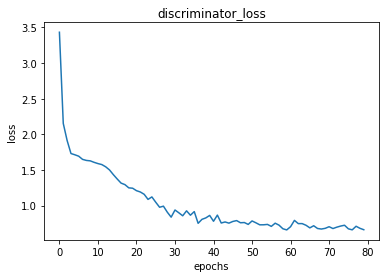

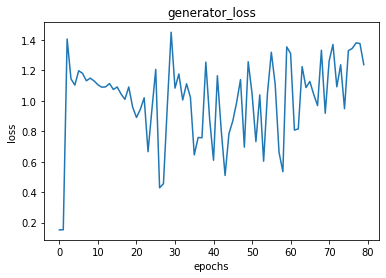

In [ ]:
losses=h5py.File('./losses_list_'+str(dcgan.text_input_dim)+'.h5','r')
d_loss_list=losses['discriminator']
d_loss_list=np.array(d_loss_list)
d_loss_list=d_loss_list.tolist()
g_loss_list=losses['generator']
g_loss_list=np.array(g_loss_list)
g_loss_list=g_loss_list.tolist()

plt.figure()
plt.title('discriminator_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(d_loss_list)

plt.figure()
plt.title('generator_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(g_loss_list)

Evaluation

In [ ]:
test_imgs=h5py.File('./test_data.h5','r')
imgs=test_imgs['imgs']
imgs=np.array(imgs)
print(imgs.shape)
names_in=open('./test_img_names.pkl','rb')
names=pickle.load(names_in)
    
with open(json_file_path,'r') as j:
    caps=json.loads(j.read())
    
captions=[]
for i in range(len(names)):
    captions.append(caps[names[i]])
    
if not os.path.exists('./skipthought_vectors_test.pkl'):
    model=skipthoughts.load_model()
    vectors=skipthoughts.encode(model,captions)
    with open('skipthought_vectors_test.pkl','wb') as f:
        pickle.dump(vectors,f)
else:
    with open('skipthought_vectors_test.pkl','rb') as f:
        vectors=pickle.load(f)

(2500, 64, 64, 3)


In [ ]:
dcgan.generator.load_weights(model_dir_path+'/dc_gan-generator'+str(dcgan.text_input_dim)+'-weights.h5')

In [ ]:
batch_size=100
n_batches_test=imgs.shape[0]//batch_size
gen_imgs=np.zeros(imgs.shape)
for i in range(n_batches_test):
    with tf.device('/gpu:0'):
        gen=dcgan.test(vectors[i*batch_size:(i+1)*batch_size],batch_size)
        gen_imgs[i*batch_size:(i+1)*batch_size]=gen

true_imgs=np.zeros((imgs.shape[0],160,160,3))
pred_imgs=np.zeros(true_imgs.shape)

for i in range(true_imgs.shape[0]):
    img=imgs[i]
    img=resize(img.astype(np.float),(160,160))
    true_imgs[i,:,:,:]=img

    img=gen_imgs[i]
    img=resize(img.astype(np.float),(160,160))
    pred_imgs[i,:,:,:]=img
print(true_imgs.shape,pred_imgs.shape)

(2500, 160, 160, 3) (2500, 160, 160, 3)


In [ ]:
facenet=load_model('facenet_keras.h5')
test_features=np.zeros((2500,128))
pred_features=np.zeros((2500,128))
for i in range(n_batches_test):
    with tf.device('/gpu:0'):
        feat=facenet.predict_on_batch(true_imgs[i*batch_size:(i+1)*batch_size])
        test_features[i*batch_size:(i+1)*batch_size]=feat
        feat=facenet.predict_on_batch(pred_imgs[i*batch_size:(i+1)*batch_size])[0]
        pred_features[i*batch_size:(i+1)*batch_size]=feat
print(pred_features.shape,test_features.shape)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(2500, 128) (2500, 128)


In [ ]:
fss=0
for i in range(len(pred_features)):
    fss+=1-spatial.distance.cosine(pred_features[i],test_features[i])
print(fss/len(pred_features))

0.29302692120087837


In [ ]:
fsd=0
for i in range(len(pred_features)):
    dist=spatial.distance.minkowski(pred_features[i],test_features[i],p=1)
    fsd+=dist
print(fsd/len(pred_features))

71.18329485432844


Test generation

In [ ]:
dcgan.generator.load_weights(model_dir_path+'/dc_gan-generator'+str(dcgan.text_input_dim)+'-weights.h5')
skipthought_model=skipthoughts.load_model()

Loading model parameters...
Compiling encoders...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Loading tables...
Packing up...


1

30
Caption: The woman has high cheekbones. She has wavy hair. She has arched eyebrows. The young attractive woman has heavy makeup. She’s wearing lipstick.


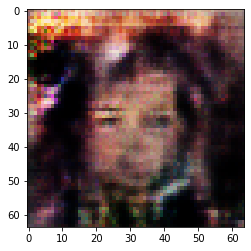

In [ ]:
caption=['The woman has high cheekbones. She has wavy hair. She has arched eyebrows. The young attractive woman has heavy makeup. She’s wearing lipstick.']
dcgan.generate_image_from_text(caption,skipthought_model)